In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import geopandas as gpd
import geodatasets


In [2]:
# Load dataset
file_path = "../data/public_emdat_custom_request_2018-2024.xlsx"
df = pd.read_excel(file_path)

print(f"Data Shape: {df.shape}")
df.head(3)


Data Shape: (4014, 47)


,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,GADM Admin Units,Entry Date,Last Update
0,2018-0040-BRA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),DFO:4576,NaN,BRA,...,NaN,NaN,NaN,10000.0,12492.0,80.049596,"[{""adm2_code"":9961,""adm2_name"":""Rio De Janeiro""}]","[{""gid_2"":""BRA.19.68_2"",""migration_date"":""2025...",2018-02-20,2025-12-20
1,2022-0770-RWA,No,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,RWA,...,NaN,NaN,NaN,NaN,NaN,93.294607,"[{""adm1_code"":21970,""adm1_name"":""Kigali City/U...","[{""gid_1"":""RWA.5_1"",""migration_date"":""2025-12-...",2022-11-25,2025-12-20
2,2024-9796-USA,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,USA,...,NaN,NaN,NaN,5400000.0,5400000.0,100.000000,NaN,"[{""gid_1"":""USA.13_1"",""name_1"":""Idaho""},{""gid_1...",2024-10-29,2025-12-20


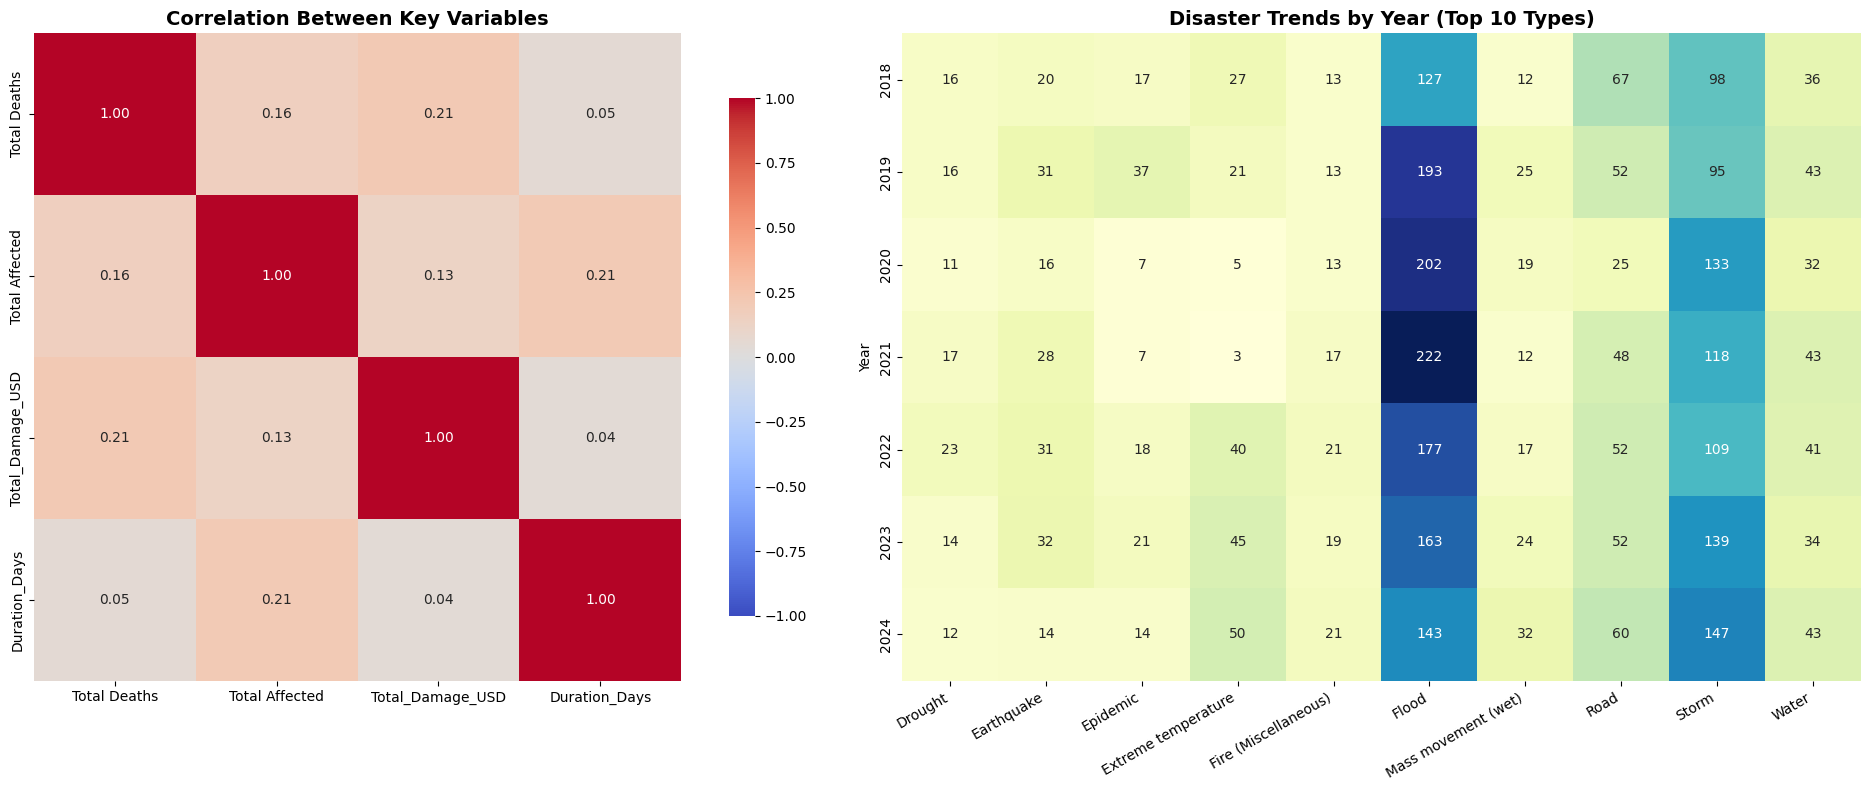

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. DATA PREPARATION ---
# Assuming df is already loaded. If not:
# df = pd.read_csv('public_emdat_custom_request_2018-2024.xlsx - EM-DAT Data.csv')

# Cleaning and transformations
if "Total Damage ('000 US$)" in df.columns:
    df.rename(columns={"Total Damage ('000 US$)": 'Total_Damage_USD'}, inplace=True)

df['Total Deaths'] = df['Total Deaths'].fillna(0)
df['Total Affected'] = df['Total Affected'].fillna(0)

# Date construction and duration calculation
df['Start Month'] = df['Start Month'].fillna(1).astype(int)
df['Start Day'] = df['Start Day'].fillna(1).astype(int)
df['End Month'] = df['End Month'].fillna(1).astype(int)
df['End Day'] = df['End Day'].fillna(1).astype(int)
df['Disaster_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)
df['End_Date'] = pd.to_datetime(
    dict(year=df['End Year'], month=df['End Month'], day=df['End Day']),
    errors='coerce'
)
df['Duration_Days'] = (df['End_Date'] - df['Disaster_Date']).dt.days
df['Duration_Days'] = df['Duration_Days'].fillna(1).clip(lower=1)

# --- 2. VISUALIZATION (Section 1) ---
# Create space for two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# A) CORRELATION MATRIX (Left)
corr_cols = ['Total Deaths', 'Total Affected', 'Total_Damage_USD', 'Duration_Days']
corr_matrix = df[corr_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    ax=axes[0],
    square=True,
    cbar_kws={"shrink": .8},
    vmin=-1,
    vmax=1
)
axes[0].set_title('Correlation Between Key Variables', fontsize=14, fontweight='bold')

# B) YEAR vs DISASTER TYPE TRENDS (Right)
# Keep only the top 10 most frequent disaster types
top_disasters = df['Disaster Type'].value_counts().nlargest(10).index
df_trend = df[df['Disaster Type'].isin(top_disasters)]
year_trend = pd.crosstab(df_trend['Start Year'], df_trend['Disaster Type'])

sns.heatmap(year_trend, cmap='YlGnBu', annot=True, fmt="d", ax=axes[1], cbar=False)
axes[1].set_title('Disaster Trends by Year (Top 10 Types)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Year')
axes[1].set_xlabel('')

# 👉 X-axis labels: rotate slightly for readability
axes[1].set_xticklabels(
    axes[1].get_xticklabels(),
    rotation=30,
    ha='right'
)

plt.tight_layout()
plt.show()



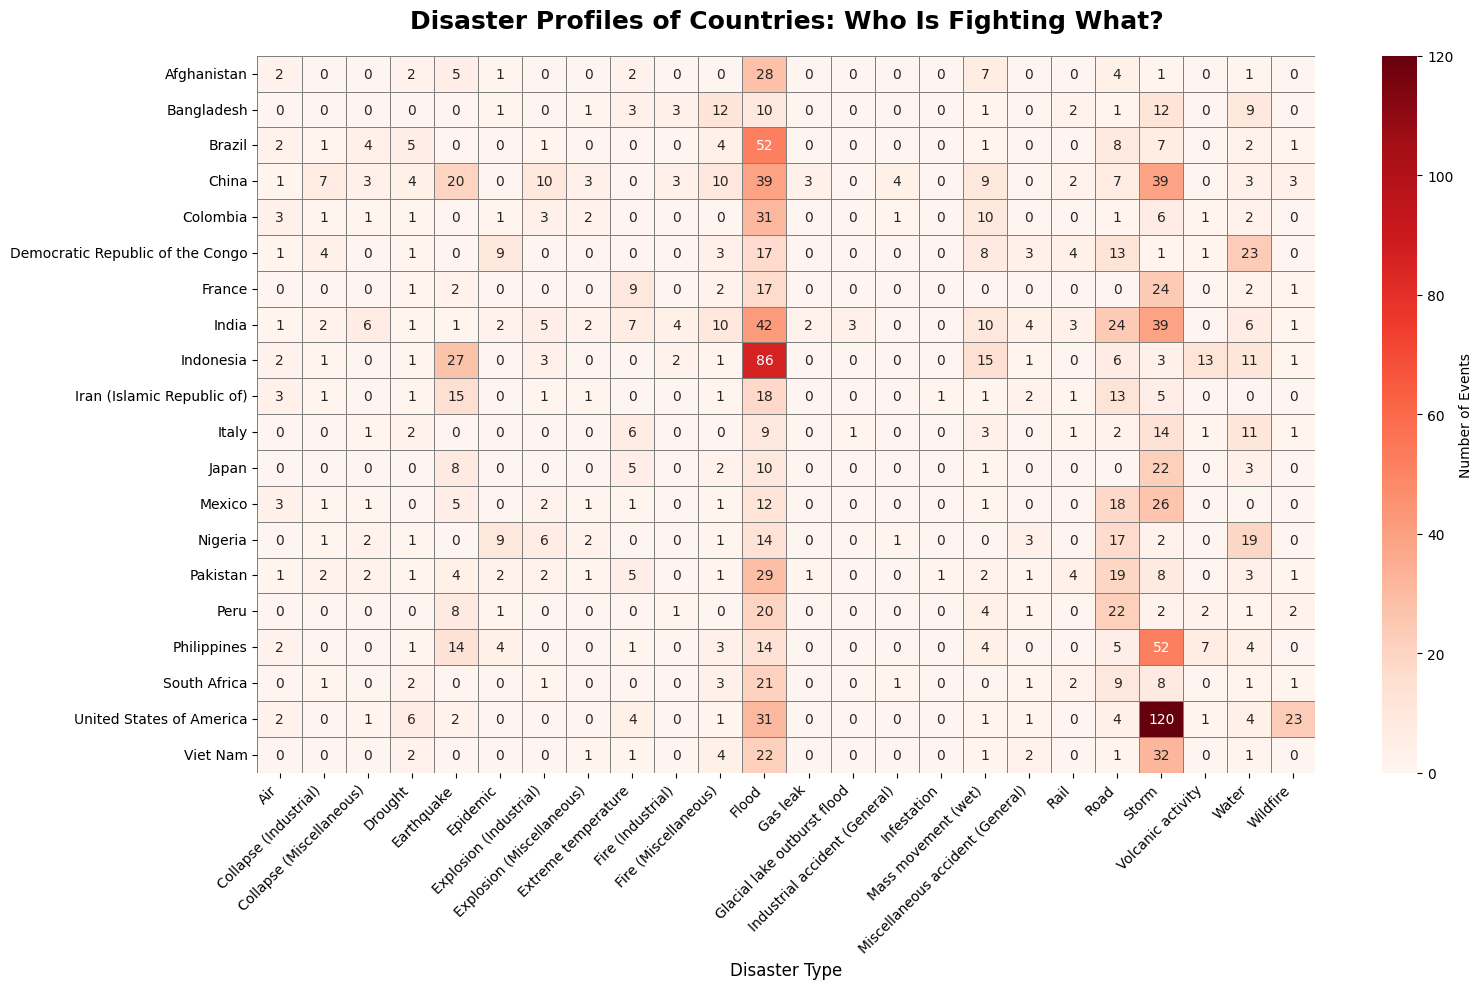

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- VISUALIZATION (Section 2: Country-Level Analysis) ---
plt.figure(figsize=(16, 10))  # Allocate a large plotting area

# Select the top 20 countries with the highest number of events
top_20_countries = df['Country'].value_counts().nlargest(20).index
df_country = df[df['Country'].isin(top_20_countries)]

# Create the matrix (Country x Disaster Type)
country_matrix = pd.crosstab(df_country['Country'], df_country['Disaster Type'])

# Draw the heatmap
sns.heatmap(
    country_matrix,
    cmap='Reds',
    annot=True,
    fmt="d",
    linewidths=.5,
    linecolor='gray',
    cbar_kws={"label": "Number of Events"}
)

# Titles and labels
plt.title(
    'Disaster Profiles of Countries: Who Is Fighting What?',
    fontsize=18,
    fontweight='bold',
    pad=20
)
plt.xlabel('Disaster Type', fontsize=12)
plt.ylabel('')
plt.xticks(rotation=45, ha='right')  # Rotate disaster names for readability

plt.tight_layout()
plt.show()
